In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
## Define your path
PATH = r"D:\francisco_madrigal\Desktop\Tesis\modelo"

def create_path(file_path, path=PATH):
    
    return os.path.join(path, file_path)

### Feature Selection

We are going to use a Lasso model to drop features that has no impact on crime.

In [3]:
## Read DataFrame
matrix_crimes = pd.read_csv(create_path("base_crimenes.csv"),
                            parse_dates =['Hora'])       

## Drop columns
matrix_crimes = matrix_crimes.drop(['id_colonia', 'Hora', 'indice', 'day', 
                                    'year', 'categoria_delito','Coordinates'], 
                               axis = 1)


"\nmatrix_crimes = matrix_crimes.drop(['id_colonia', 'Hora', 'indice', 'day', \n                                    'year', 'categoria_delito','Coordinates',\n                                   'day_period', 'dia_semana', 'month'], \n                               axis = 1)\n\n"

In [4]:
## Create x and y train datasets
X_train = matrix_crimes.drop(['crimen'], axis = 1).copy()
y_train = matrix_crimes['crimen'].copy()

del matrix_crimes

In [5]:

X_train = pd.get_dummies(X_train, columns=['day_period', 'dia_semana', 'month'],
                         prefix=["day_per", "weekday", "month"], 
                         drop_first=True)


In [6]:
## Create a list of columns that are not categorical and can be scaled
scaler_cont_cols = ['past_near_crimes_500mts',
                   'past_crimes', 'TEMP', 'PRCP', 'CO', 'O3', 'PM10',
                   'area_km2', 'metro', 'metrobus', 'rtp', 'supers_minisupers',
                   'department_stores', 'banks', 'corporate_offices', 'restaurants',
                   'g_edu', 'no_healt_s', 'pop_per_km2', 'house_per_km2']

## init scaler
scaler = StandardScaler()

## Separate continous variables from the training dataset and fit
scaler.fit(X_train[scaler_cont_cols])

## Transform
X_train_scale = scaler.transform(X_train[scaler_cont_cols])

## Convert to Pandas Dataframe
X_train_scale = pd.DataFrame(X_train_scale, columns=scaler_cont_cols)

## Join scaled continuos variables and dummies
X_train = X_train.drop(scaler_cont_cols, axis = 1)
X_train.reset_index(inplace=True, drop=True)
X_train = X_train_scale.join(X_train)

del X_train_scale

In [7]:
## Fit CV Lasso
lasso_cv = LassoCV(cv=StratifiedShuffleSplit(n_splits=5), 
                  n_alphas=100).fit(X_train, y_train)

## Get the best alpha
best_alpha = lasso_cv.alpha_

## Run Lasso with best alpha
lasso = Lasso(alpha=best_alpha).fit(X_train, y_train)

## Crate a table with the coeficients
coef_table = pd.Series(lasso.coef_, X_train.columns).sort_values(ascending = False)
coef_table = pd.DataFrame(coef_table).reset_index()
coef_table.columns = ['Coeficients', "Beta"]

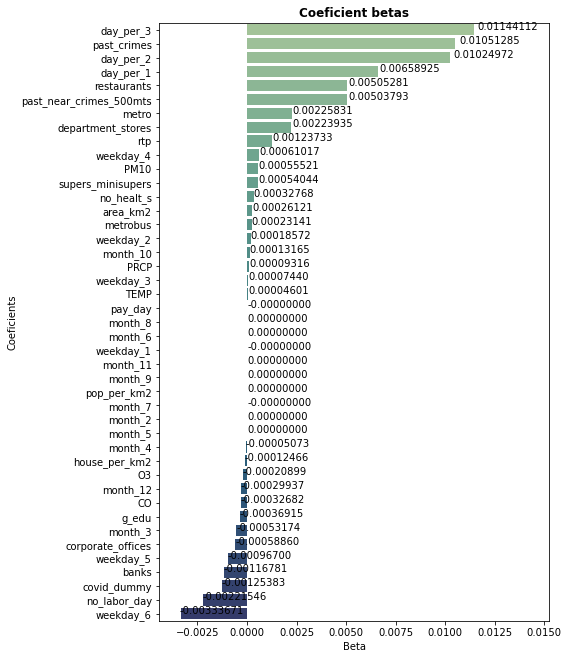

In [12]:
## Plot the betas
fig = plt.figure(figsize=(7, 11))

ax = fig.subplots(1, 1)

sns.barplot(x="Beta", y="Coeficients", data=coef_table,
            palette="crest", ax=ax)

for i, v in enumerate(coef_table['Beta']):
    
    ax.text(x= v + v/60, y= i, s='{:,.8f}'.format(v), horizontalalignment='left', fontsize=10)
    
for tick in ax.get_xticklabels():
        tick.set_fontsize(10) 

max_x = max(coef_table['Beta']) + max(coef_table['Beta'])/3
min_x = min(coef_table['Beta']) + min(coef_table['Beta'])/3
ax.set_xlim(min_x, max_x)

ax.set_title('Coeficient betas', fontweight="bold")

plt.show()

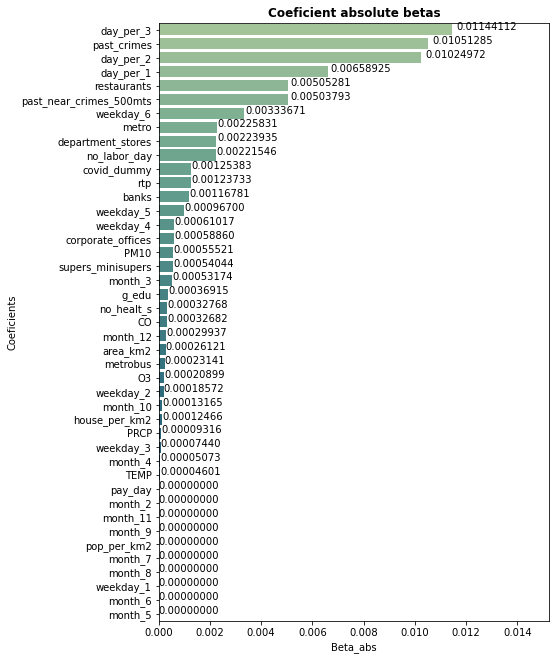

In [11]:
## Plot betas absolute value
coef_table['Beta_abs'] = coef_table['Beta'].abs()

coef_table.sort_values(by='Beta_abs', ascending = False, inplace=True)

## Plot 
fig = plt.figure(figsize=(7, 11))

ax = fig.subplots(1, 1)

sns.barplot(x="Beta_abs", y="Coeficients", data=coef_table,
            palette="crest", ax=ax)

for i, v in enumerate(coef_table['Beta_abs']):
    
    ax.text(x= v + v/60, y= i, s='{:,.8f}'.format(v), horizontalalignment='left', fontsize=10)
    
for tick in ax.get_xticklabels():
        tick.set_fontsize(10) 

max_x = max(coef_table['Beta_abs']) + max(coef_table['Beta_abs'])/3
min_x = min(coef_table['Beta_abs']) + min(coef_table['Beta_abs'])/3
ax.set_xlim(min_x, max_x)

ax.set_title('Coeficient absolute betas', fontweight="bold")

plt.show()

Based on the results of the Lasso regresion, we can discard some variables that can outperfom our model: pay_day, pop_per_km2 and most of the month had little impact on crime. 